# Análise da turbina eólica

## Introdução

Energia eólica é a energia cinética proveniente da força de massas de ar em movimento (ventos), que é captada pelas turbinas dos aerogeradores e convertida em eletricidade.

Este material encontra-se dividido em três etapas: 
* 1ª Etapa:Tratamento dos dados;
* 2ª Etapa: Análises dos dados e conclusões;
* 3º Etapa: Predições da energia produzida;

## Objeto de análise:

A turbina em análise está sendo ativada por massas de ar. Assim, ela está produzindo energia elétrica.

**A potência de uma turbina eólica está relacionada com alguns parâmetros:**

* velocidade do vento;
* eficiência do gerador;
* massa específica do ar;
* área do rotor.

`VELOCIDADE DO VENTO:` é o principal parâmetro analisado, pois é a partir da sua velocidade que é gerada a energia cinética que esta será convertida em energia elétrica no gerador. Por isso, a angulação do vento entre ele a turbina é um fator pontual, pois a depender a direção que o vento está, ela não irá gerar movimento nas hélices.


## Objetivos

**OBJETIVOS DA EMPRESA:** A empresa `HEnergiaRenovável` delimitou as seguintes imposições e pedidos:
* Um relatório técnico sobre a análise;
* Identificar quais direções de vento produzem maiores erros; OK
* Entender a relação entre velocidade do vento e potência produzida e gerar inferências; OK
* Produção de energia pela hora do dia; OK
* Produção mensal de energia; OK
* Gráficos de comparação entre a potência real e a potência teórica; OK
* Um arquivo csv contendo os dados não nulos de potência;
* Um sistema de predição de potência a partir do banco de dados;
* Dados com 5% para mais ou para menos do limite teórico devem ser desconsiderados.


## Informações sobre o dataset e limitações

O dataset nos forcene os seguintes dados:

* Data da medição - medição em intervalos de 10 minutos;
* Potência ativa em kW - potência gerada pela fonte eólica;
* Velocidade do vento em m/s;
* Potência teórica em kwH;
* Direção do vento em graus.


**FONTE:**
* https://www.kaggle.com/berkerisen/wind-turbine-scada-dataset
* https://www.kaggle.com/akdagmelih/wind-turbine-power-prediction-gbtregressor-pyspark/notebook


**LIMITAÇÕES DA ANÁLISE:**
* Algumas medições não foram registradas.

## Metodologia
* Para as análises e limpezada dos dados foi utilizada a linguagem de programação Python com a interface do Jupyter.

* Para as análises estatísticas foram utilizadas bibliotecas do Python.



# 1º ETAPA: Tratamento do dados

In [262]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

**IMPORTANTO O DATAFRAME E FAZENDO AS VERIFICAÇÕES**

In [64]:
turbina_df = pd.read_csv('archive/T1.csv')
turbina_df.head(3)

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789


In [65]:
turbina_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [66]:
# criando um dicionário para renomear as colunas
colunas = {
    'Date/Time':'data/tempo',
    'LV ActivePower (kW)':'potencia_ativa',
    'Wind Speed (m/s)':'velocidade_vento',
    'Theoretical_Power_Curve (KWh)':'potencia_teorica',
    'Wind Direction (°)':'direcao_vento'
}

# renomenado as colunas
turbina_df.rename(columns=colunas, inplace=True)

# mudando o formato da coluna do tempo para datetime
turbina_df['data/tempo'] = pd.to_datetime(turbbina_df['data/tempo'])

# colocando o índice como a coluna do datetime
turbina_df.set_index('data/tempo', inplace=True)

# visualizando o dataframe modificado
turbina_df.head(3)

,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento
data/tempo,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789


In [67]:
turbina_df.describe()

,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


# 2º ETAPA: Análise de dados

## Quantidade mensal de produção de energia

Existe alguma diferença entre os meses para a produção média de energia?

In [123]:
colunas = {
    1:'Janeiro',
    2:'Fevereiro',
    3:'Março',
    4:'Abril',
    5:'Maio',
    6:'Junho',
    7:'Julho',
    8:'Agosto',
    9:'Setembro',
    10:'Outubro',
    11:'Novembro',
    12:'Dezembro'
}

# criando o dataframe dos meses
energia_mensal = turbina_df.groupby(turbina_df.index.month).mean()

# renomeando as colunas dos índices
energia_mensal.rename(index=colunas, inplace=True)

# renomeando o nome da coluna dos índices
energia_mensal.index.name = 'Meses'

# vizualizando o dataframe
energia_mensal

,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento
Meses,,,,
Janeiro,1469.538834,9.407847,2051.432742,137.723051
Fevereiro,1398.812191,8.179499,1670.969069,124.670508
Março,1778.547254,9.204149,1899.451986,157.674416
Abril,1062.471714,6.740089,1186.013869,94.857182
Maio,1099.212305,6.693869,1271.246602,104.178431
Junho,1168.209523,6.844458,1330.927093,133.941694
Julho,694.432261,5.474675,781.056052,148.386055
Agosto,1510.816574,8.050320,1695.374114,88.250307
Setembro,1491.921321,7.704346,1601.570319,107.495466


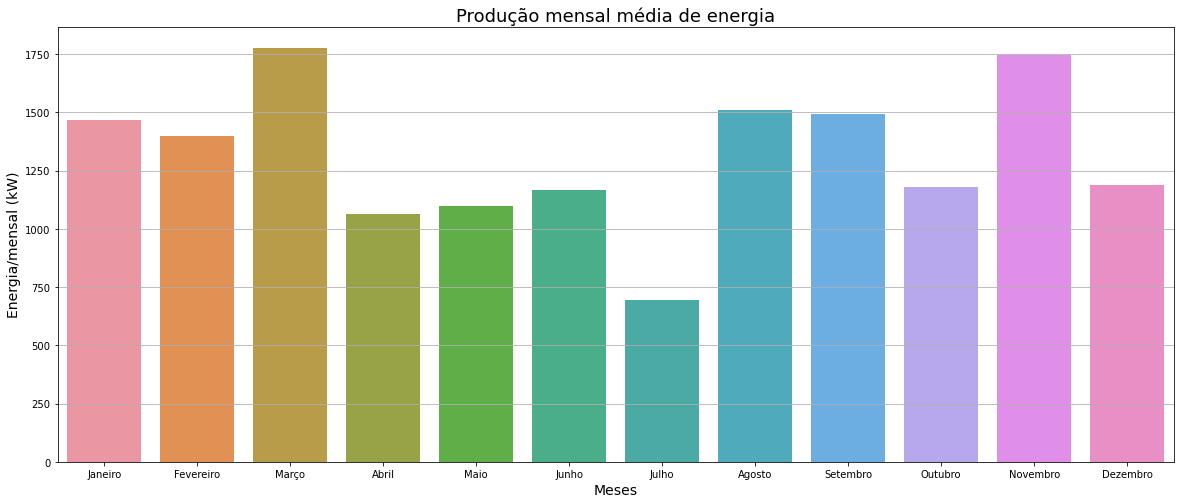

In [122]:
plt.figure(figsize=(20, 8))
plt.grid()
ax = sns.barplot(x=energia_mensal.index, y='potencia_ativa', data=energia_mensal)
ax.set_title('Produção mensal média de energia', fontsize=18)
ax.set_ylabel('Energia/mensal (kW)', fontsize=14)
ax.set_xlabel('Meses', fontsize=14)
ax = ax

**RESPOSTA:** Sim, existe uma diferença média de produção de energia. Os meses três piores meses são Julho, Maio e Abril. Sendo que nesses o mês de menor produção é Julho.

## Quantidade diária de produção de energia

Existe alguma diferença entre as horas para a produção média de energia?

In [128]:
# agrupando o dataframe da energia produzina por hora
energia_hora = turbina_df.groupby(turbina_df.index.hour).mean()

# renomeando o nome da coluna e do índice
energia_hora.columns.name = 'features'
energia_hora.index.name = 'Hora do dia'

# visualizando o dataframe
energia_hora

features,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento
Hora do dia,,,,
0,1385.044023,7.850671,1568.735677,133.480092
1,1375.151801,7.885823,1568.980273,131.191982
2,1382.937343,7.886549,1575.770090,131.531560
3,1375.325266,7.890250,1578.654134,130.114486
4,1393.639176,7.885168,1588.432064,128.740767
5,1323.467826,7.681868,1515.403518,127.089092
6,1243.540404,7.351122,1417.321563,124.988257
7,1178.739047,7.093343,1343.307290,124.730761
8,1091.950881,6.923616,1267.907163,123.608422


<bound method Artist.set of <AxesSubplot:title={'center':'Produção hora/média de energia'}, xlabel='Hora', ylabel='Energia/hora (kW)'>>

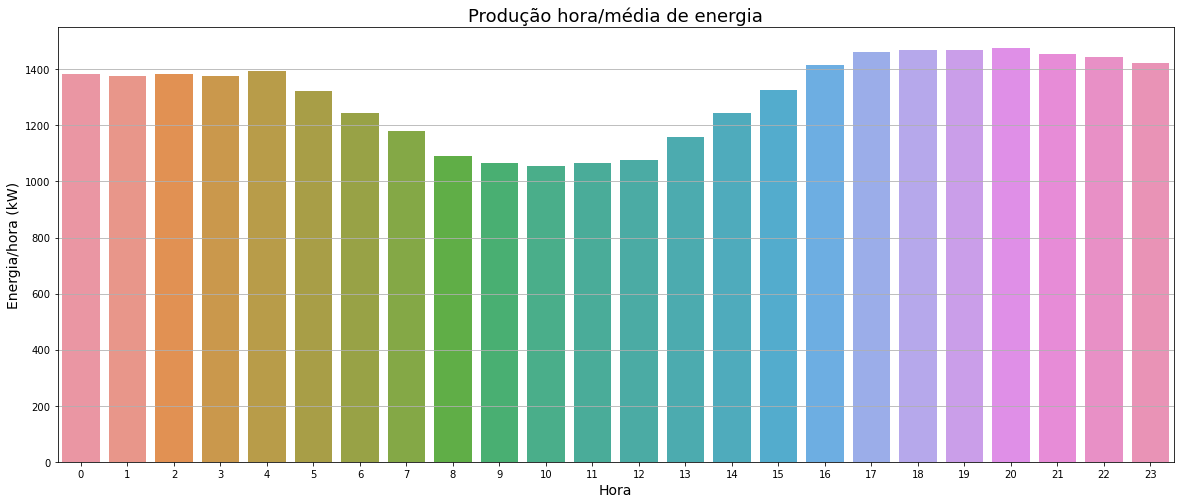

In [129]:
plt.figure(figsize=(20, 8))
plt.grid()
ax = sns.barplot(x=energia_hora.index, y='potencia_ativa', data=energia_hora)
ax.set_title('Produção hora/média de energia', fontsize=18)
ax.set_ylabel('Energia/hora (kW)', fontsize=14)
ax.set_xlabel('Hora', fontsize=14)
ax.set

**RESPOSTA:** Sim, existe diferença na produção de energia na hora. A menor produção ocorre entre 8 e 12 horas e a maior produção durante 16 e 20 horas. Provavelmente, a maritimidade interfere nessa produção.

## Existe alguma correlação entre a velocidade do vento, a direção do vento e a produção de energia?

In [134]:
plt.figure(figsize=(20, 8))
turbina_df.corr()

,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento
potencia_ativa,1.000000,0.912774,0.949918,-0.062702
velocidade_vento,0.912774,1.000000,0.944209,-0.077188
potencia_teorica,0.949918,0.944209,1.000000,-0.099076
direcao_vento,-0.062702,-0.077188,-0.099076,1.000000


<Figure size 1440x576 with 0 Axes>

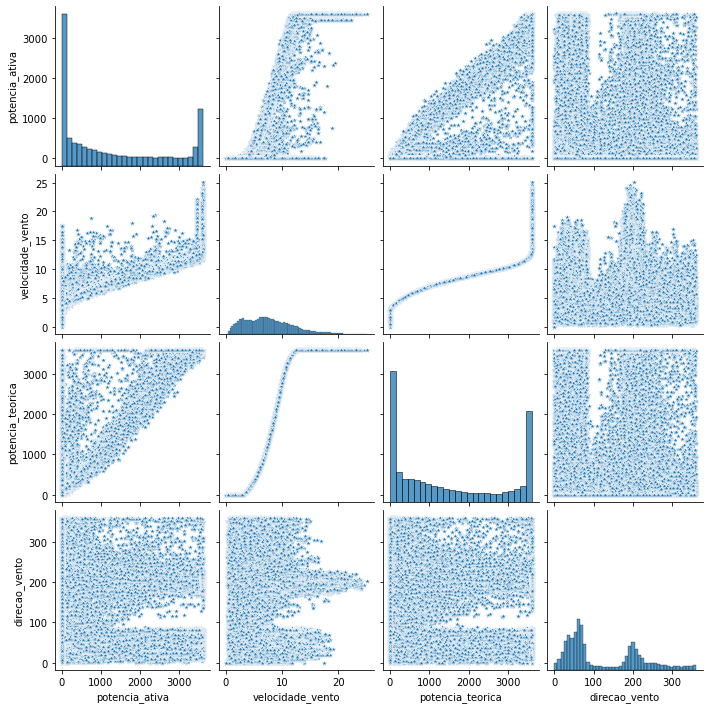

In [135]:
sns.pairplot(turbina_df, markers='*')

**RESPOSTA:** A velocidade do vento e a produção de energia estão altamente correlacionadas, como seria de esperar. Podemos ver que há produção de energia de nível inferior para algumas direções de vento.

## Qual é o nível médio de saída de energia para diferentes velocidades do vento?

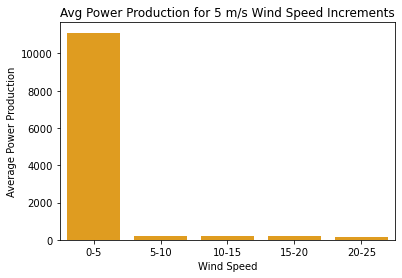

In [145]:
# Finding average power production for 5 m/s wind speed increments

classes = [
    0,
    5,
    10,
    15,
    20,
    25
]

labels = ['0-5', '5-10', '10-15', '15-20', '20-25']

metricas = pd.value_counts(
  pd.cut(x = turbina_df.potencia_ativa,
         bins = classes,
         labels = labels,
         include_lowest = True)
)

metricas = metricas.to_frame()


sns.barplot(x=metricas.index, y='potencia_ativa', color='orange', data=metricas)
plt.title('Avg Power Production for 5 m/s Wind Speed Increments')
plt.xlabel('Wind Speed')
plt.ylabel('Average Power Production');


## Qual é a potência de saída para diferentes direções e velocidades do vento?

In [146]:
turbina_df.columns

Index(['potencia_ativa', 'velocidade_vento', 'potencia_teorica',
       'direcao_vento'],
      dtype='object')

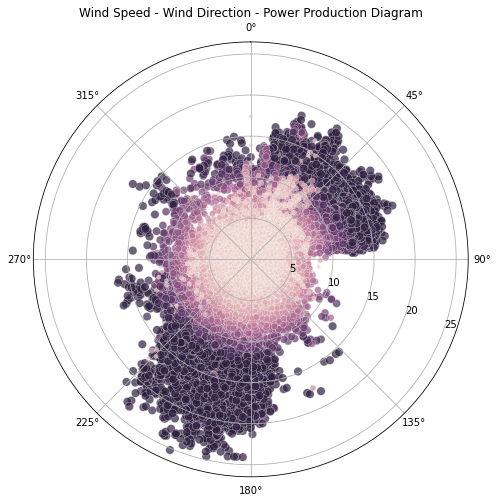

In [149]:
from math import radians

plt.figure(figsize=(20, 8))
ax = plt.subplot(111, polar=True)

# Inside circles are the wind speed and marker color and size represents the amount of power production
sns.scatterplot(x=[radians(x) for x in turbina_df.direcao_vento], 
                y=turbina_df.velocidade_vento,
                size=turbina_df.potencia_ativa,
                hue=turbina_df.potencia_ativa,
                alpha=0.7, legend=None)

# Setting the polar diagram's top represents the North 
ax.set_theta_zero_location('N')
# Setting -1 to start the wind direction clockwise
ax.set_theta_direction(-1)
# Setting wind speed labels in a better position to see
ax.set_rlabel_position(110)
plt.title('Wind Speed - Wind Direction - Power Production Diagram', fontsize=18)
plt.ylabel(None);

## Velocidade de cu de rola

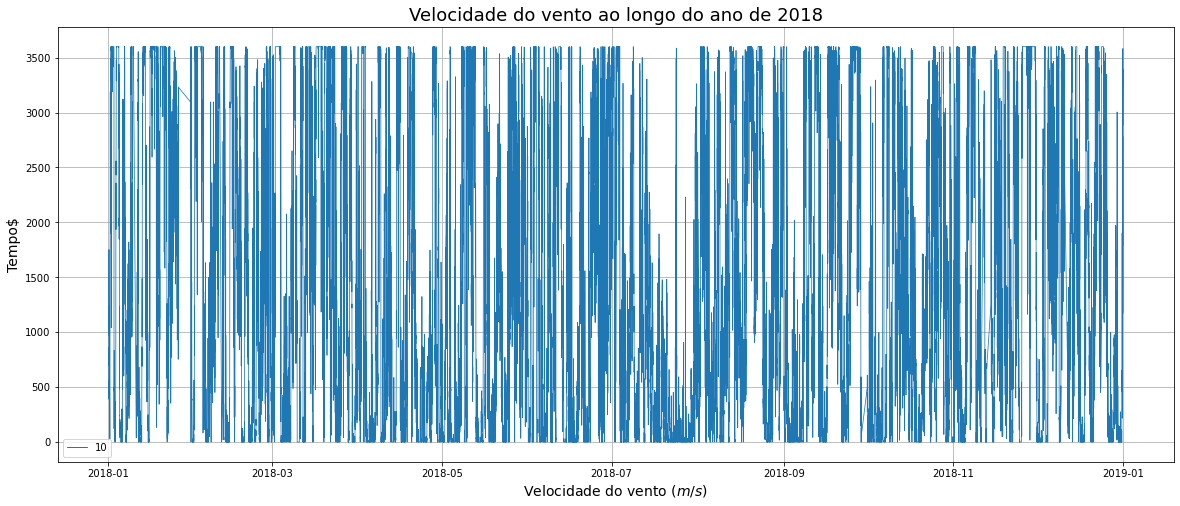

In [310]:
filtro = turbina_df[(turbina_df.index.month >= 2018) & (turbina_df.index.month < 2019)]

plt.figure(figsize=(20, 8))
ax = sns.lineplot(x=turbina_df.index, y=turbina_df.potencia_teorica, data=turbina_df[filtro], size=10)
ax.set_title('Velocidade do vento ao longo do ano de 2018', fontsize=18)
ax.set_xlabel('Velocidade do vento $(m/s)$', fontsize=14)
ax.set_ylabel('Tempo', fontsize=14)
plt.grid()

## Velocidade do vento e produção de energia

Text(0.5, 0, 'Potência produzida (kW)')

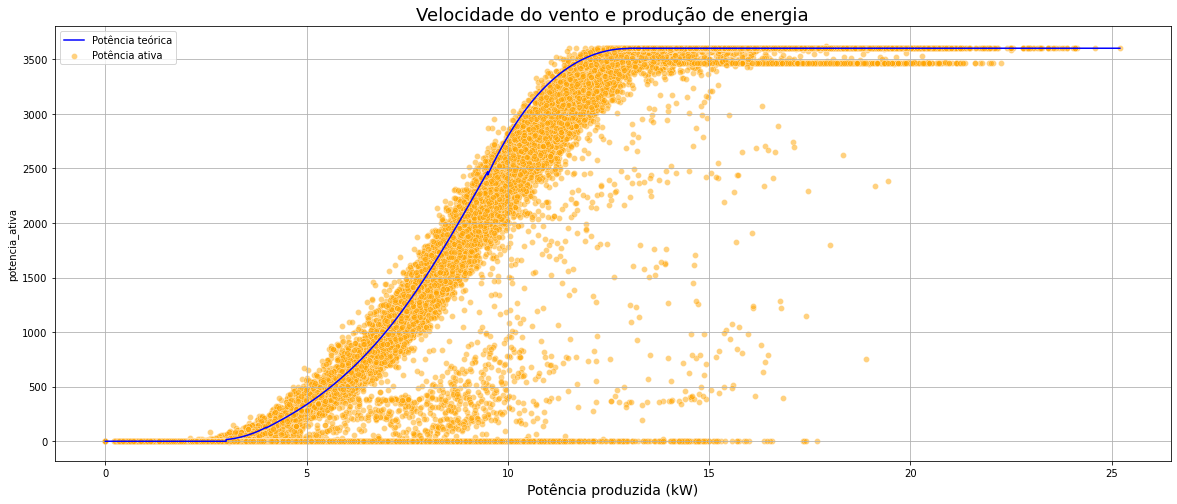

In [162]:
plt.figure(figsize=(20, 8))


sns.scatterplot(x=turbina_df.velocidade_vento, y=turbina_df.potencia_ativa,
                     data=turbina_df, color='orange', alpha=0.5, label='Potência ativa')

sns.lineplot(x=turbina_df.velocidade_vento, y=turbina_df.potencia_teorica,
             data=turbina_df, color='blue', label='Potência teórica')

plt.grid()
plt.title("Velocidade do vento e produção de energia", fontsize=18)
plt.xlabel("Velocidade do vento (m/s)", fontsize=14)
plt.xlabel("Potência produzida (kW)", fontsize=14)



**TEÓRICO**

A relação entre a `velocidade do vento` e a `potência teórica` é positiva, isto é, o aumento da velocidade causa o aumento da potência. Além disso, observar-se que a potência tem um limite máximo, isto é, a partir da velocidade de 11 m/s, a potência produzida alcança o seu valor máximo e existe uma velocidade mínima para começar a produzir potência.

<hr>

**REAL**

A relação entre a `velocidade do vento` e a `potência ativa` é positiva, isto é, o aumento da velocidade causa o aumento da potência. Além disso, observar-se que a potência tem um limite máximo, isto é, a partir da velocidade de 11 m/s, a potência produzida alcança o seu valor máximo e existe uma velocidade mínima para começar a produzir potência. Cabe salientar que, existem muitas medições zeradas, pois no momento da aferição não foi possível captar a potência produzida, apesar de haver velocidades de vento com energia suficiente para produzir energia.


A partir do gráfico acima, podemos ver que a curva teórica de produção de energia geralmente se encaixa bem com a produção real.

Podemos ver que a produção de energia atinge um nível máximo e continua em linha reta se a velocidade do vento atingir 15 m/s.

Também podemos ver que existem cerca de 0 potência de saída, mesmo a velocidade do vento é superior a 5 m / s. Quero investigar o motivo.

Mas antes qual é a velocidade mínima do vento para a curva teórica de produção de energia?

**COMPARAÇÃO ENTRE A POTÊNCIA TEÓRICA E REAL**

De forma geral, encontra-se muita mais potências abaixo dos valores teóricos do que acima.

Pode-se analisar de uma forma bem rúde a potência:

$P = v_{vento}.\eta_{rotor}$

onde:

$\eta_{rotor}$ considera-se como valor constante;

$v_{vento}$ é um valor variável.

Portanto, nos pontos em que a potência supera a teoria pode-se considerar que alguns parâmetro relacionado ao vento influênciou nesse resultado como também uma aferição errônea. Já nos pontos em que o valor real está abaixo do valor teórico, considera-se normal, pois é esperada a perda de energia devido ao rendimento do motor e perdas por atrito.

<hr>

### Qual é o valor limite da velocidade do vento para potência teórica zero?

Text(0, 0.5, 'Distribuição para 0 produção de energia')

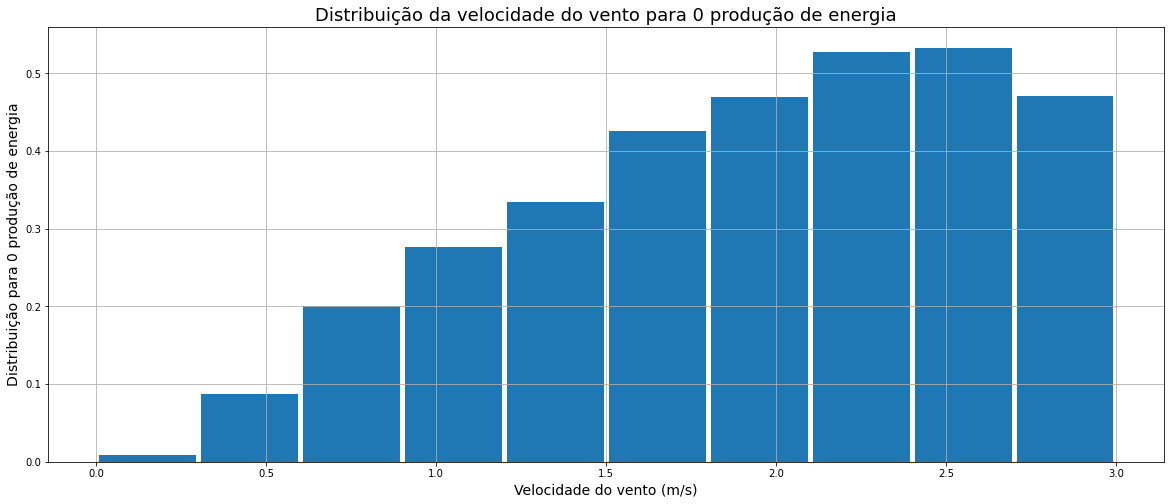

In [245]:
# criando o dataframe
potencia_zero = turbina_df.query(expr='(potencia_teorica == 0) and (potencia_ativa == 0)')

# plotando o histograma
plt.figure(figsize=(20, 8))
plt.grid()
plt.hist(x=potencia_zero.velocidade_vento, density=True, rwidth=0.95)
plt.title('Distribuição da velocidade do vento para 0 produção de energia', fontsize=18)
plt.xlabel('Velocidade do vento (m/s)', fontsize=14)
plt.ylabel('Distribuição para 0 produção de energia', fontsize=14)

Podemos ver pelo gráfico acima, o limite para a curva de potência teórica é de 3 m/s de velocidade do vento. Se a velocidade do vento for inferior a 3 m/s, o modelo não prevê qualquer produção de energia.

Mas existem algumas observações para produção de energia 0, mesmo que a velocidade do vento seja superior a 3 m / s.

### Por que não há produção de energia em algumas observações enquanto a velocidade do vento é superior a 3 m/s?

Text(0, 0.5, 'Distribuição para 0 produção de energia')

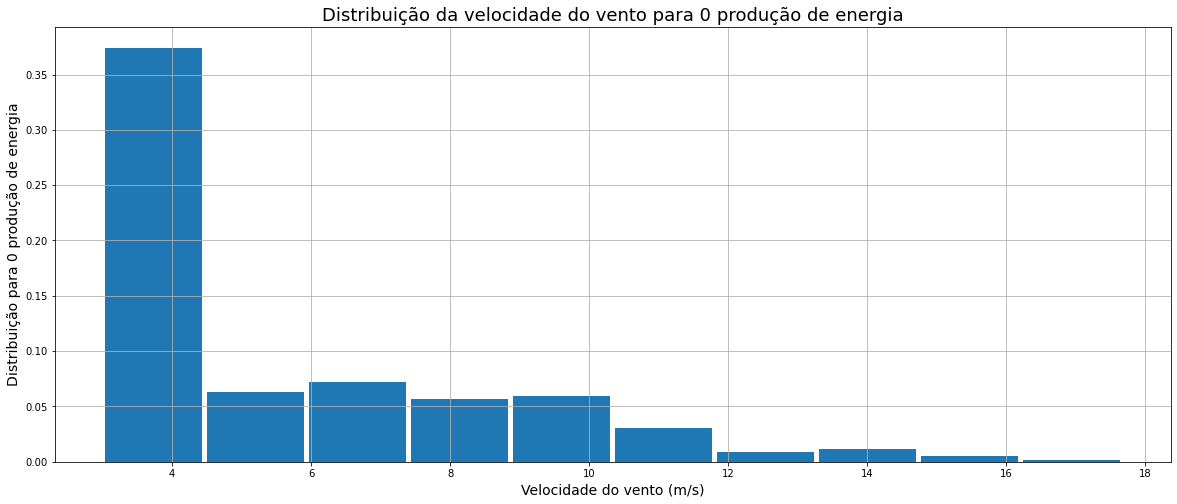

In [260]:
# criando o dataframe
potencia_zero = turbina_df.query(expr='(potencia_teorica != 0) and (potencia_ativa == 0) and (velocidade_vento > 3)')

# criando o histograma
plt.figure(figsize=(20, 8))
plt.grid()
plt.hist(x=potencia_zero.velocidade_vento, density=True, rwidth=0.95)
plt.title('Distribuição da velocidade do vento para 0 produção de energia', fontsize=18)
plt.xlabel('Velocidade do vento (m/s)', fontsize=14)
plt.ylabel('Distribuição para 0 produção de energia', fontsize=14)

In [255]:
print(f'Existem {potencia_zero.shape[0]} registros onde a velocidade do vento é superior a 3 m/s e não tem potência sendo produzida/registrada')

Existem 3497 registros onde a velocidade do vento é superior a 3 m/s e não tem potência sendo produzida/registrada


Parece que teoricamente o limite de velocidade do vento deve ser de 4 m/s. Mas também há outras observações com produção de energia zero enquanto a velocidade do vento é maior.

Assim, nesta análise estes registros serão considerados outliers.


### Verificando outros outliers

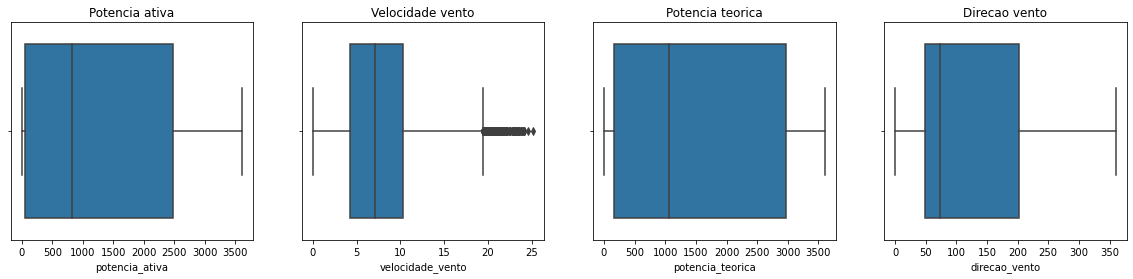

In [268]:
columns = turbina_df.columns
i=1
plt.figure(figsize=(20, 4))
for each in columns:
    df = turbina_df[each]
    plt.subplot(1,4,i)
    sns.boxplot(df)
    plt.title(each.upper().replace('_',' ').capitalize())
    i += 1

Pelo gráfico acima é possível inferir que a velocidade do vento tem alguns valores que devem ser investigados.

In [269]:


# Defining the quantiles and interquantile range
Q1 = turbina_df.velocidade_vento.quantile(0.25)
Q3 = turbina_df.velocidade_vento.quantile(0.75)
IQR = Q3-Q1
# Defining the lower and upper threshold values
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

print('Quantile (0.25): ', Q1, '  Quantile (0.75): ', Q3)
print('Lower threshold: ', lower, ' Upper threshold: ', upper)

Quantile (0.25):  4.201395392417902   Quantile (0.75):  10.30001997947685
Lower threshold:  -4.946541488170519  Upper threshold:  19.447956860065272


In [274]:
# Fancy indexing for outliers
outlier_tf = ((turbina_df.velocidade_vento < lower) | (turbina_df.velocidade_vento > upper))

data/tempo
2018-04-15 17:10:00    False
2018-02-14 07:40:00     True
2018-10-16 13:10:00    False
2018-01-13 04:40:00    False
2018-12-18 03:30:00    False
Name: velocidade_vento, dtype: bool

In [285]:
print('Total Number of Outliers: ', turbina_df.velocidade_vento[outlier_tf].shape[0])
print('--'*15)
print('Some Examples of Outliers:')
turbina_df.velocidade_vento[outlier_tf].sample(10).to_frame()

Total Number of Outliers:  423
------------------------------
Some Examples of Outliers:


,velocidade_vento
data/tempo,
2018-11-26 19:00:00,19.474409
2018-02-02 01:20:00,20.282330
2018-04-02 02:00:00,20.268511
2018-04-02 03:00:00,20.245741
2018-11-26 17:30:00,20.101049
2018-01-02 22:30:00,21.753340
2018-03-02 23:40:00,23.580330
2018-03-02 19:00:00,21.600750
2018-01-20 15:50:00,19.618349


Pergunta: Quais são os critérios gerais para a produção de energia?
É importante entender o padrão nos dados. Devemos aprender os dados antes da máquina.

1. Vimos pelo gráfico que em março, agosto e novembro, a produção média de energia é maior.

2. A potência média é maior diariamente entre as 16:00 e as 24:00.

3. A potência é maior quando o vento sopra das direções entre 000-090 e 180-225 graus.

Então, vamos tentar prever um nível alto e baixo de produção de energia a partir dos critérios acima antes do algoritmo ML.

Text(0, 0.5, 'Potencia ativa $(kw)$')

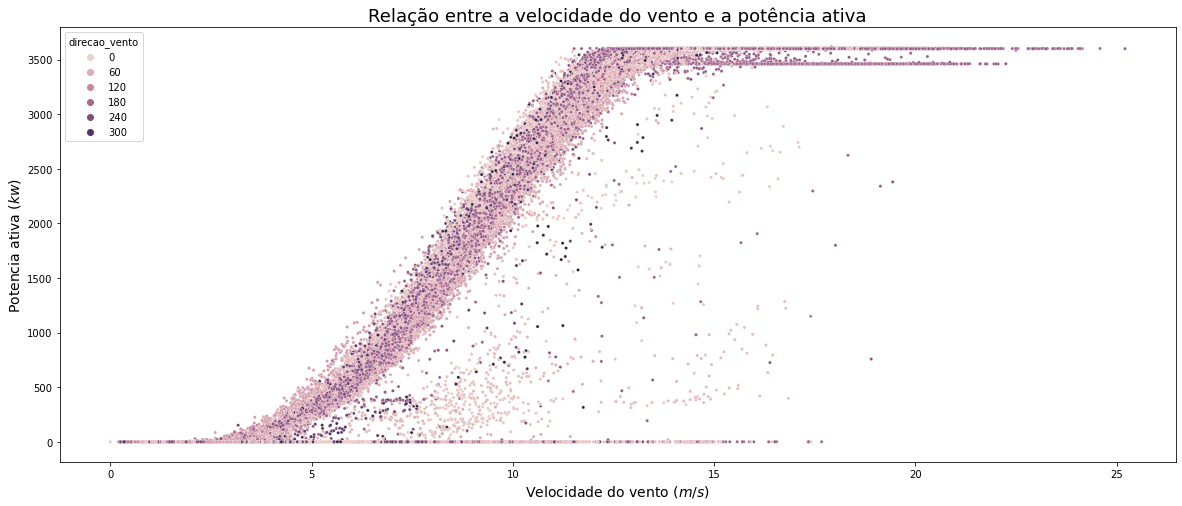

In [11]:
plt.figure(figsize=(20,8))
ax = sns.scatterplot(x=turbinas_df.velocidade_vento_ms, y=turbinas_df.potencia_ativa_kw,
                     data=turbinas_df, hue=turbinas_df.direcao_vento, s=10)

ax.set_title('Relação entre a velocidade do vento e a potência ativa', fontsize=18)
ax.set_xlabel('Velocidade do vento $(m/s)$', fontsize=14)
ax.set_ylabel('Potencia ativa $(kw)$', fontsize=14)

In [302]:
turbina_df['erro'] = round((abs(turbina_df.potencia_ativa - turbina_df.potencia_teorica) / turbina_df.potencia_teorica)*100, 2)

In [303]:
turbina_df.sample(3)

,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento,limite,erro
data/tempo,,,,,,
2018-09-25 09:00:00,2977.658936,10.719110,3163.983273,31.229620,potencia_fora_do_limite,5.89
2018-07-18 08:40:00,0.000000,1.862072,0.000000,0.336787,potencia_dentro_do_limite,NaN
2018-02-25 07:30:00,81.000092,7.731864,1380.390168,37.100750,potencia_fora_do_limite,94.13


In [14]:
turbinas_df.erro_de_potencia.describe()

count    43246.0000
mean            inf
std             NaN
min          0.0000
25%          4.4025
50%         12.3300
75%         22.3500
max             inf
Name: erro_de_potencia, dtype: float64

In [15]:
potencia_zero = turbinas_df[turbinas_df.potencia_ativa_kw == 0]
potencia_zero.head(10)

,potencia_ativa_kw,velocidade_vento_ms,potencia_teorica_kwh,direcao_vento,erro_de_potencia
time,,,,,
2018-03-01 15:40:00,0.0,3.743307,83.986265,245.068207,100.0
2018-03-01 16:10:00,0.0,2.142016,0.000000,234.762405,NaN
2018-03-01 16:20:00,0.0,2.501406,0.000000,223.308807,NaN
2018-03-01 16:30:00,0.0,2.668578,0.000000,226.051697,NaN
2018-03-01 16:40:00,0.0,3.034003,17.180593,221.086502,100.0
2018-03-01 16:50:00,0.0,3.197354,25.431221,232.679596,100.0
2018-03-01 17:00:00,0.0,3.907811,110.979604,241.973099,100.0
2018-04-01 12:40:00,0.0,2.888112,0.000000,0.000000,NaN
2018-04-01 12:50:00,0.0,2.386636,0.000000,139.275101,NaN


In [16]:
potencia_sem_zero = turbinas_df[turbinas_df.potencia_ativa_kw != 0]
potencia_sem_zero.head()

,potencia_ativa_kw,velocidade_vento_ms,potencia_teorica_kwh,direcao_vento,erro_de_potencia
time,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,8.71
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,12.72
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,21.62
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,18.69
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,22.59


Text(0, 0.5, 'Potencia ativa $(kw)$')

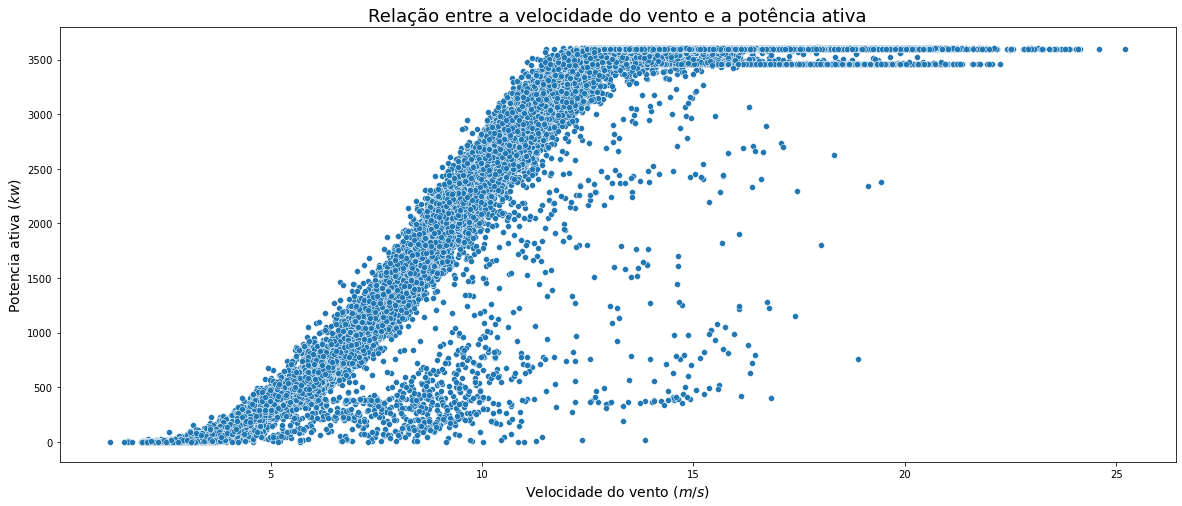

In [17]:
plt.figure(figsize=(20,8))
ax = sns.scatterplot(x='velocidade_vento_ms', y='potencia_ativa_kw',
                     data=potencia_sem_zero)

ax.set_title('Relação entre a velocidade do vento e a potência ativa', fontsize=18)
ax.set_xlabel('Velocidade do vento $(m/s)$', fontsize=14)
ax.set_ylabel('Potencia ativa $(kw)$', fontsize=14)

### Criando um filtro 

A empresa pediu um df com o filtro de 5% para cima e para baixo

In [287]:
# transformando as Series em listas
pot_real= turbina_df.potencia_ativa.tolist()
pot_teorica = turbina_df.potencia_teorica.tolist()

# variáveis auxiliares
pot_max=[]
pot_min=[]
dentro_limite = []

# limite
i = 5

for potencia in pot_teorica:
    pot_max.append(potencia*(1 + i/100))
    pot_min.append(potencia*(1 - i/100))

for p, potencia in enumerate(pot_real):
    if potencia>=pot_min[p] and potencia<=pot_max[p]:
        dentro_limite.append('potencia_dentro_do_limite')
    elif potencia==0:
        dentro_limite.append('potencia_igual_0')
    else:
        dentro_limite.append('potencia_fora_do_limite')

turbina_df['limite'] = dentro_limite
    

In [290]:
turbina_df.sample(5)

,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento,limite
data/tempo,,,,,
2018-04-12 02:40:00,1377.410034,7.648657,1335.678100,106.274200,potencia_dentro_do_limite
2018-08-20 00:30:00,3530.871094,12.961640,3597.779234,58.370560,potencia_dentro_do_limite
2018-03-05 11:50:00,4.324685,2.932024,0.000000,65.966988,potencia_fora_do_limite
2018-05-20 11:00:00,312.400391,5.135857,370.089941,18.399080,potencia_fora_do_limite
2018-11-22 05:20:00,0.000000,0.639368,0.000000,266.465393,potencia_dentro_do_limite


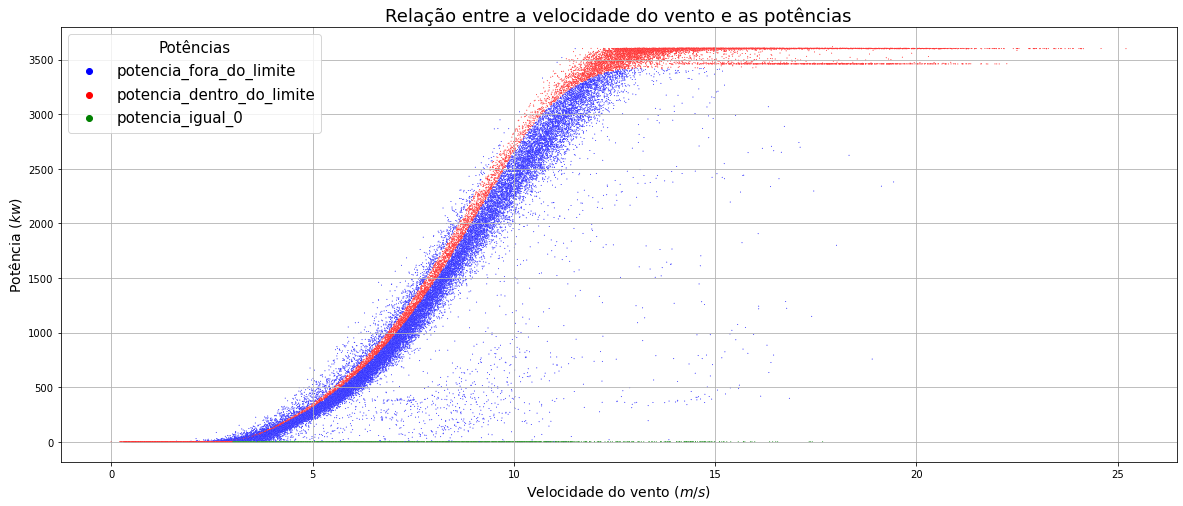

In [299]:
plt.figure(figsize=(20, 8))
plt.grid(True)

cores = {
    'potencia_dentro_do_limite':'red',
    'potencia_igual_0':'green',
    'potencia_fora_do_limite':'blue'
}
ax = sns.scatterplot(x=turbina_df.velocidade_vento, y=turbina_df.potencia_ativa,
                     data=turbina_df, hue=turbina_df.limite, s=1,
                    palette=cores)

ax.set_title('Relação entre a velocidade do vento e as potências', fontsize=18)
ax.set_xlabel('Velocidade do vento $(m/s)$', fontsize=14)
ax.set_ylabel('Potência $(kw)$', fontsize=14)



plt.legend(title='Potências', title_fontsize=15, prop={'size': 15})


In [22]:
potencias_limite = turbinas_df[turbinas_df.limite == 'potencia_dentro_do_limite']
potencias_limite.head()

,potencia_ativa_kw,velocidade_vento_ms,potencia_teorica_kwh,direcao_vento,erro_de_potencia,limite
time,,,,,,
2018-01-01 02:40:00,742.985291,6.378913,759.434537,266.593292,2.17,potencia_dentro_do_limite
2018-01-01 02:50:00,748.229614,6.446653,785.281010,265.571808,4.72,potencia_dentro_do_limite
2018-01-01 03:00:00,736.647827,6.415083,773.172863,261.158691,4.72,potencia_dentro_do_limite
2018-01-01 03:10:00,787.246216,6.437531,781.771216,257.560211,0.70,potencia_dentro_do_limite
2018-01-01 03:20:00,722.864075,6.220024,700.764700,255.926498,3.15,potencia_dentro_do_limite


Text(0, 0.5, 'Direção do vento')

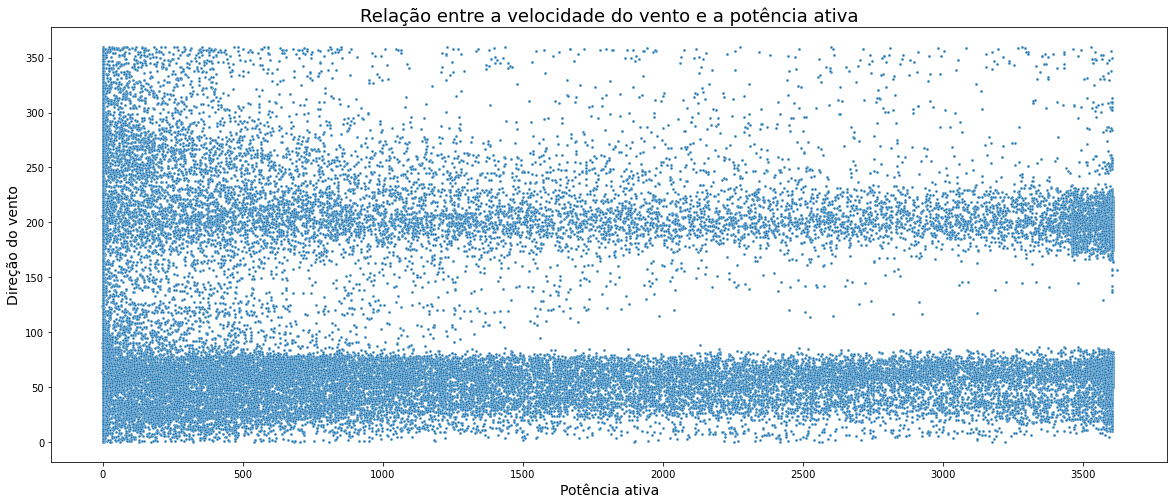

In [25]:
plt.figure(figsize=(20,8))
ax = sns.scatterplot(x=turbinas_df.potencia_ativa_kw, y=turbinas_df.direcao_vento,
                     data=turbinas_df, s=8)

ax.set_title('Relação entre a velocidade do vento e a potência ativa', fontsize=18)
ax.set_xlabel('Potência ativa', fontsize=14)
ax.set_ylabel('Direção do vento', fontsize=14)

Text(0, 0.5, 'Direção do vento')

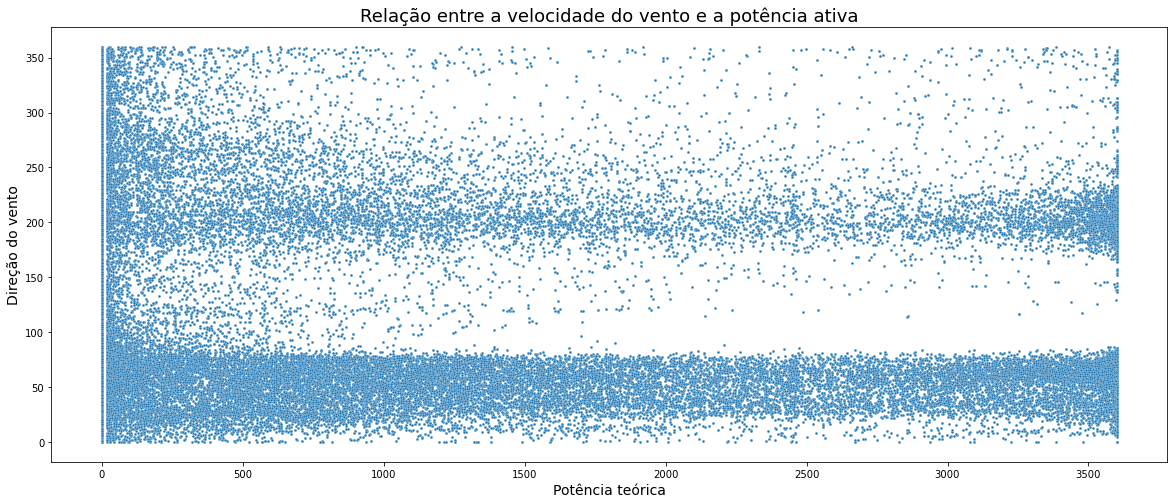

In [26]:
plt.figure(figsize=(20,8))
ax = sns.scatterplot(x=turbinas_df.potencia_teorica_kwh, y=turbinas_df.direcao_vento,
                     data=turbinas_df, s=8)

ax.set_title('Relação entre a velocidade do vento e a potência ativa', fontsize=18)
ax.set_xlabel('Potência teórica', fontsize=14)
ax.set_ylabel('Direção do vento', fontsize=14)

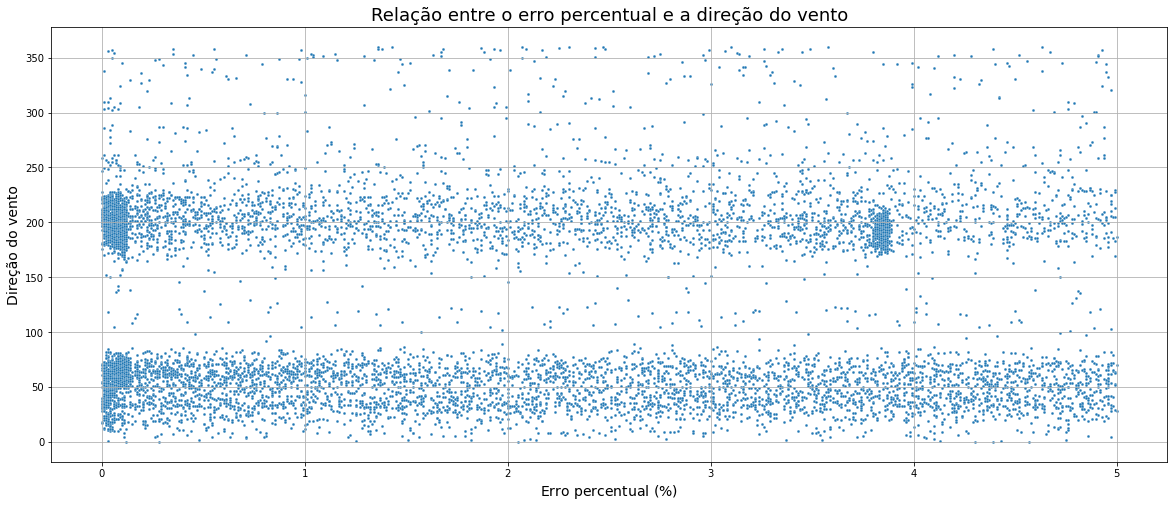

In [27]:
dentro_do_limite = turbinas_df.query('limite == "potencia_dentro_do_limite"')
plt.figure(figsize=(20,8))
ax = sns.scatterplot(x=dentro_do_limite.erro_de_potencia, y=dentro_do_limite.direcao_vento,
                     data=dentro_do_limite, s=8)

ax.set_title('Relação entre o erro percentual e a direção do vento', fontsize=18)
ax.set_xlabel('Erro percentual $(\%)$', fontsize=14)
ax.set_ylabel('Direção do vento', fontsize=14)
plt.grid()


**CONCLUSÃO:** A partir do gráfico acima pode-se perceber que há uma concentração de erros nas angulações de 50º a 200º com os respectivos desvios. Por isso, recomenda-se a verificação da aferições nessas direções.